# Volcano plot

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed
import scipy
import re
from adjustText import adjust_text
import pylab
import random
from ast import literal_eval as make_tuple

from matplotlib import font_manager as fm, rcParams
fpath = os.path.join(rcParams["datapath"], "fonts/ttf/arial.ttf")
prop_label = fm.FontProperties(fname=fpath)
prop_label.set_size(30)
prop_ticks = fm.FontProperties(fname=fpath)
prop_ticks.set_size(25)
fname = os.path.split(fpath)[1]


sns.set_style("whitegrid")
sns.set_context('paper')

aggregat = 'median'

In [2]:
results_folder = './figures/'
figure_folder = './figures/volcano/'

## Read TCGA

In [8]:
TCGA_ustat_df = pd.read_csv('%s/TCGA_ustat_summary_aggregat_median.csv'%(results_folder), index_col=[0,1], header=[0,1])
TCGA_ustat_df.index.names = ['GDSC_drug', 'TCGA_drug']
TCGA_df = TCGA_ustat_df

## Read HMF

In [9]:
HMF_ustat_df = pd.read_csv('%s/HMF_ustat_summary_aggregat_median.csv'%(results_folder), index_col=[0,1], header=[0,1])
HMF_ustat_df.index.names = ['GDSC_drug', 'HMF_drug']
HMF_df = HMF_ustat_df[['PRECISE', 'baseline_C', 'TRANSACT']]

In [10]:
TCGA_df = TCGA_df.reset_index()
TCGA_df['TCGA_drug'] = TCGA_df['TCGA_drug'] + '_TCGA'
HMF_df = HMF_df.reset_index()
HMF_df['HMF_drug'] = HMF_df['HMF_drug'] + '_HMF'

## Concatenate results

In [11]:
whole_results_df = pd.concat([
    TCGA_df.rename(columns={'TCGA_drug': 'drug'}),
    HMF_df.rename(columns={'HMF_drug': 'drug'})
])
whole_results_df = whole_results_df.dropna(1)
whole_results_df.to_csv('%s/aggregated_results.csv'%(figure_folder))

In [13]:
colors = [mpl.colors.TABLEAU_COLORS['tab:red'],
          mpl.colors.TABLEAU_COLORS['tab:green'],
          mpl.colors.TABLEAU_COLORS['tab:blue']]

## Agregated results

In [14]:
es_label = 'AUC'
method = 'baseline'

colors_drugs = {
    'Carboplatin_HMF': '#1f77b4',
    'Carboplatin_TCGA': '#ff7f0e',
    'Cisplatin_TCGA': '#2ca02c',
    'Etoposide_TCGA': '#d62728',
    'Gemcitabine_HMF': '#9467bd',
    'Gemcitabine_TCGA': '#8c564b',
    'Irinotecan_HMF': '#e377c2',
    'Oxaliplatin_TCGA': '#bcbd22',
    'Paclitaxel_TCGA': '#17becf',
    'Trastuzumab_HMF': '#FFEFD5',
    'Trastuzumab_TCGA': '#FF8C00',
    'Vinorelbine_TCGA': 'skyblue'
}

methods = ['baseline_C', 'PRECISE', 'TRANSACT']

In [15]:
for m in methods:
    whole_results_df[(m, 'log_pval')] = - np.log10(whole_results_df[(m, 'pval')])

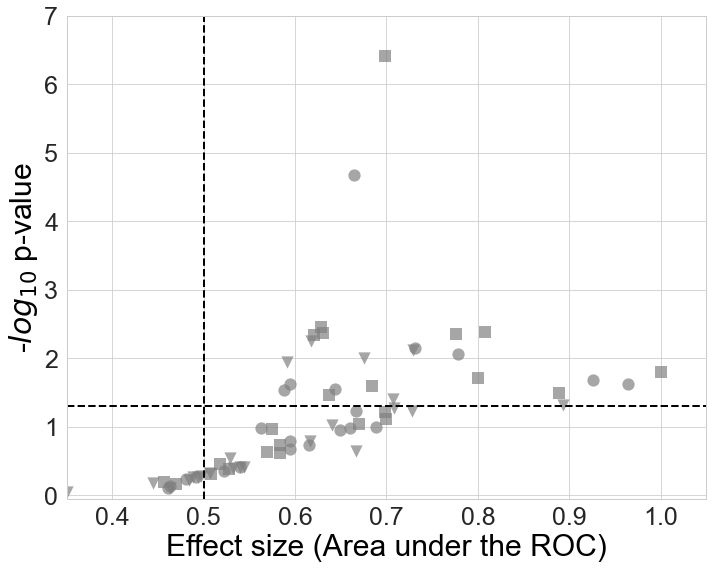

<Figure size 1080x1800 with 0 Axes>

In [16]:
# Plot with grey
fig = pylab.figure(figsize=(10,8))
figlegend = pylab.figure(figsize=(15,25))
ax = fig.add_subplot(111)

ts = []
x = []
y = []
sp = [None]*3
for i, (method, marker) in enumerate(zip(methods, ['v','o', 's'])):
    
    sp[i] = sns.scatterplot(data=whole_results_df,
                            x=(method, es_label),
                            y=(method,'log_pval'),
                            marker=marker,
                            s=150,
                            alpha=0.7,
                            linewidth=0,
                            color='grey',
                            edgecolor="black",
                            ax=ax)
        
xticks = ax.get_xticks()
if es_label == 'mean_diff':
    ax.hlines(np.log10(20), -.05, 0.15, linewidth=2, linestyles='--')
elif es_label == 'cohen':
    ax.hlines(np.log10(20), -.5, 4, linewidth=2, linestyles='--')
elif es_label == 'AUC':
    ax.hlines(np.log10(20), 0.35, 1.05, linewidth=2, linestyles='--')
    ax.vlines(0.5, -.05, 7, linewidth=2, linestyles='--')

for label in ax.get_xticklabels():
    label.set_fontproperties(prop_ticks)
for label in ax.get_yticklabels():
    label.set_fontproperties(prop_ticks)
    
x_label = '$\Delta$mean' if es_label == 'mean_diff' else ('Cohen d' if es_label == 'cohen' else 'Area under the ROC')
ax.set_xlabel('Effect size (%s)'%(x_label), color='black', fontproperties=prop_label)
ax.set_ylabel('-$log_{10}$ p-value', color='black', fontproperties=prop_label)

if es_label == 'cohen':
    ax.set_xlim(-0.5, 4)
elif es_label == 'mean_diff':
    ax.set_xlim(-.05, 0.15)
elif es_label == 'AUC':
    ax.set_xlim(.35, 1.05)
ax.set_ylim(-0.05,7)

fig.tight_layout()
fig.savefig('%s/transparent_support_results_%s.png'%(figure_folder, es_label), dpi=300,
            transparent=False)

## One plot per drug

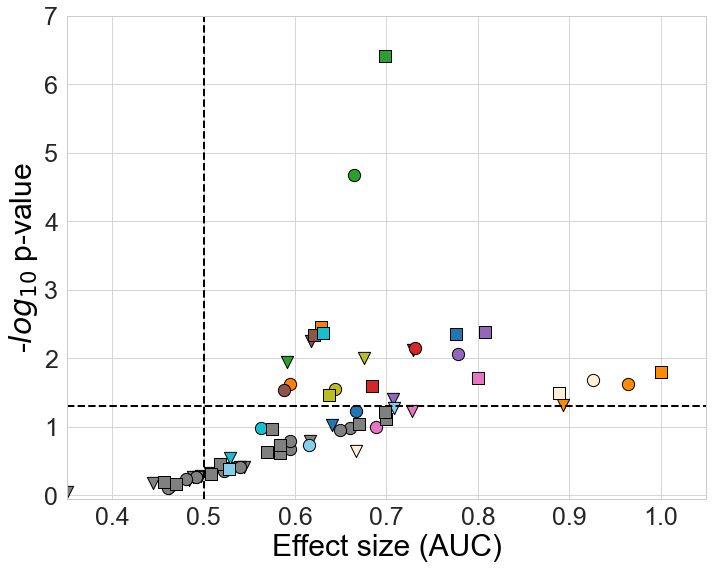

<Figure size 1080x1800 with 0 Axes>

In [19]:
unique_drugs = np.unique(whole_results_df['drug'])

fig = pylab.figure(figsize=(10,8))
figlegend = pylab.figure(figsize=(15,25))
ax = fig.add_subplot(111)

ts = []
x = []
y = []
sp = [None]*3

for i, (method, marker) in enumerate(zip(methods, ['v','o', 's'])):
    for d in unique_drugs:
        sp[i] = sns.scatterplot(data=whole_results_df[whole_results_df['drug'].str.contains(d)],
                                x=(method, es_label),
                                y=(method,'log_pval'),
                                marker=marker,
                                s=150,
                                alpha=1,
                                linewidth=1,
                                color=colors_drugs[d] if d in colors_drugs else 'grey',
                                edgecolor="black",
                                ax=ax)
        
xticks = ax.get_xticks()
if es_label == 'mean_diff':
    ax.hlines(np.log10(20), -.05, 0.15, linewidth=2, linestyles='--')
elif es_label == 'cohen':
    ax.hlines(np.log10(20), -.5, 4, linewidth=2, linestyles='--')
elif es_label == 'AUC':
    ax.hlines(np.log10(20), 0.35, 1.05, linewidth=2, linestyles='--')
    ax.vlines(0.5, -.05, 7, linewidth=2, linestyles='--')

pylab.figlegend(*ax.get_legend_handles_labels(), loc = 'upper left', ncol=2, fontsize=30, markerscale=4)
figlegend.tight_layout()
figlegend.savefig('legend.png', dpi=300)

for label in ax.get_xticklabels():
    label.set_fontproperties(prop_ticks)
for label in ax.get_yticklabels():
    label.set_fontproperties(prop_ticks)
x_label = '$\Delta$mean' if es_label == 'mean_diff' else ('Cohen d' if es_label == 'cohen' else es_label)
ax.set_xlabel('Effect size (%s)'%(x_label), color='black', fontproperties=prop_label)
ax.set_ylabel('-$log_{10}$ p-value', color='black', fontproperties=prop_label)

if es_label == 'cohen':
    ax.set_xlim(-0.5, 4)
elif es_label == 'mean_diff':
    ax.set_xlim(-.05, 0.15)
elif es_label == 'AUC':
    ax.set_xlim(.35, 1.05)
ax.set_ylim(-0.05,7)

fig.tight_layout()
fig.savefig('%s/aggregated_results_%s.png'%(figure_folder, es_label), dpi=300,
            transparent=True)


## Global picture

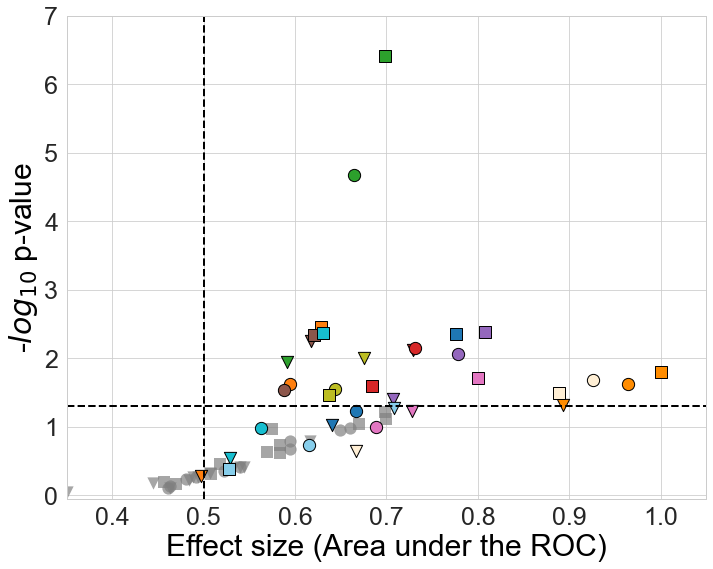

<Figure size 1080x1800 with 0 Axes>

In [27]:
# Plot with grey
fig = pylab.figure(figsize=(10,8))
figlegend = pylab.figure(figsize=(15,25))
ax = fig.add_subplot(111)

# Shaded plots
ts = []
x = []
y = []
sp = [None]*3
for i, (method, marker) in enumerate(zip(methods, ['v','o', 's'])):
    
    sp[i] = sns.scatterplot(data=whole_results_df,
                            x=(method, es_label),
                            y=(method,'log_pval'),
                            marker=marker,
                            s=150,
                            alpha=0.7,
                            linewidth=0,
                            color='grey',
                            edgecolor="black",
                            ax=ax)
    
# Plot each significant points
for i, (method, marker) in enumerate(zip(methods, ['v','o', 's'])):
    for d in unique_drugs:
        if d not in colors_drugs:
            continue
        sp[i] = sns.scatterplot(data=whole_results_df[whole_results_df['drug'].str.contains(d)],
                                x=(method, es_label),
                                y=(method,'log_pval'),
                                marker=marker,
                                s=150,
                                alpha=1,
                                linewidth=1,
                                color=colors_drugs[d] if d in colors_drugs else 'grey',
                                edgecolor="black",
                                ax=ax)
        
        
xticks = ax.get_xticks()
if es_label == 'mean_diff':
    ax.hlines(np.log10(20), -.05, 0.15, linewidth=2, linestyles='--')
elif es_label == 'cohen':
    ax.hlines(np.log10(20), -.5, 4, linewidth=2, linestyles='--')
elif es_label == 'AUC':
    ax.hlines(np.log10(20), 0.35, 1.05, linewidth=2, linestyles='--')
    ax.vlines(0.5, -.05, 7, linewidth=2, linestyles='--')

for label in ax.get_xticklabels():
    label.set_fontproperties(prop_ticks)
for label in ax.get_yticklabels():
    label.set_fontproperties(prop_ticks)
    
x_label = '$\Delta$mean' if es_label == 'mean_diff' else ('Cohen d' if es_label == 'cohen' else 'Area under the ROC')
ax.set_xlabel('Effect size (%s)'%(x_label), color='black', fontproperties=prop_label)
ax.set_ylabel('-$log_{10}$ p-value', color='black', fontproperties=prop_label)

if es_label == 'cohen':
    ax.set_xlim(-0.5, 4)
elif es_label == 'mean_diff':
    ax.set_xlim(-.05, 0.15)
elif es_label == 'AUC':
    ax.set_xlim(.35, 1.05)
ax.set_ylim(-0.05,7)

fig.tight_layout()
fig.savefig('%s/global_plot_%s_transparent.png'%(figure_folder, es_label), dpi=300,
            transparent=True)
fig.savefig('%s/global_plot_%s_background.png'%(figure_folder, es_label), dpi=300,
            transparent=False)